<a href="https://colab.research.google.com/github/Zzz-Khan-00/Handwritten-character-recognition/blob/main/Zaid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision.datasets import EMNIST
import torchvision.transforms as T
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

# Hyperparameters

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 20

# Dataset and DataLoader

In [ ]:
transform = T.Compose([
    lambda img: T.functional.rotate(img, -90),
    lambda img: T.functional.hflip(img),
    T.ToTensor(),
    T.Normalize(mean=0.1307, std=0.3081)
])

In [ ]:
train_dataset = EMNIST(root="./", split="balanced", download=True, train=True, transform=transform)
train_dataset

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7f8d1f7700e0>
               <function <lambda> at 0x7f8d1f770170>
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

In [ ]:
test_dataset = EMNIST(root="./", split="balanced", download=True, train=False, transform=transform)
test_dataset

Dataset EMNIST
    Number of datapoints: 18800
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7f8d1f7700e0>
               <function <lambda> at 0x7f8d1f770170>
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


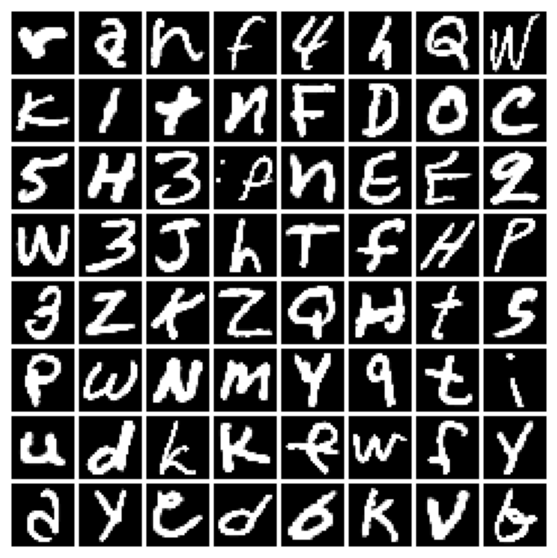

In [ ]:
images, labels = next(iter(train_loader))
img_grid = make_grid(images[:64, ...], pad_value=1, nrows=10)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img_grid.permute(1,2,0))

# Model

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = self.conv_block(1, 8)
        self.conv2 = self.conv_block(8, 16)
        self.conv3 = self.conv_block(16, 32)
        self.fc = nn.Sequential(
            nn.Linear(in_features=288, out_features=128),
            nn.ReLU(),
            nn.Linear(128, 47)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(-1, 3*3*32)
        x = self.fc(x)
        return x

    def conv_block(self, in_channels,  out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

In [ ]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1):

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
model = model.to(device)

Using GPU


# Training

In [ ]:
model.train()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
costs = []
acc_list = []
total_step = len(train_loader)

In [ ]:
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        # Forward prop
        outputs = model(images).cpu()
        loss = criterion(outputs, labels)
        costs.append(loss.item())

        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #  Tracking Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/20], Step [100/882], Loss: 0.9921, Accuracy: 71.88%
Epoch [1/20], Step [200/882], Loss: 0.8347, Accuracy: 76.56%
Epoch [1/20], Step [300/882], Loss: 0.5954, Accuracy: 78.91%
Epoch [1/20], Step [400/882], Loss: 0.5663, Accuracy: 81.25%
Epoch [1/20], Step [500/882], Loss: 0.4787, Accuracy: 82.81%
Epoch [1/20], Step [600/882], Loss: 0.5782, Accuracy: 82.81%
Epoch [1/20], Step [700/882], Loss: 0.6012, Accuracy: 82.81%
Epoch [1/20], Step [800/882], Loss: 0.4703, Accuracy: 83.59%
Epoch [2/20], Step [100/882], Loss: 0.4063, Accuracy: 86.72%
Epoch [2/20], Step [200/882], Loss: 0.4878, Accuracy: 89.06%
Epoch [2/20], Step [300/882], Loss: 0.4198, Accuracy: 89.84%
Epoch [2/20], Step [400/882], Loss: 0.3603, Accuracy: 89.06%
Epoch [2/20], Step [500/882], Loss: 0.3524, Accuracy: 85.16%
Epoch [2/20], Step [600/882], Loss: 0.4852, Accuracy: 85.16%
Epoch [2/20], Step [700/882], Loss: 0.4718, Accuracy: 85.16%
Epoch [2/20], Step [800/882], Loss: 0.3832, Accuracy: 85.16%
Epoch [3/20], Step [100/

Epoch [17/20], Step [700/882], Loss: 0.2543, Accuracy: 87.50%
Epoch [17/20], Step [800/882], Loss: 0.2179, Accuracy: 88.28%
Epoch [18/20], Step [100/882], Loss: 0.2022, Accuracy: 92.19%
Epoch [18/20], Step [200/882], Loss: 0.2853, Accuracy: 92.19%
Epoch [18/20], Step [300/882], Loss: 0.1766, Accuracy: 91.41%
Epoch [18/20], Step [400/882], Loss: 0.1768, Accuracy: 94.53%
Epoch [18/20], Step [500/882], Loss: 0.2175, Accuracy: 89.06%
Epoch [18/20], Step [600/882], Loss: 0.3482, Accuracy: 92.97%
Epoch [18/20], Step [700/882], Loss: 0.2402, Accuracy: 88.28%
Epoch [18/20], Step [800/882], Loss: 0.2158, Accuracy: 89.84%
Epoch [19/20], Step [100/882], Loss: 0.1980, Accuracy: 90.62%
Epoch [19/20], Step [200/882], Loss: 0.2776, Accuracy: 92.97%
Epoch [19/20], Step [300/882], Loss: 0.1608, Accuracy: 92.97%
Epoch [19/20], Step [400/882], Loss: 0.1536, Accuracy: 96.09%
Epoch [19/20], Step [500/882], Loss: 0.2136, Accuracy: 89.06%
Epoch [19/20], Step [600/882], Loss: 0.3555, Accuracy: 92.97%
Epoch [1

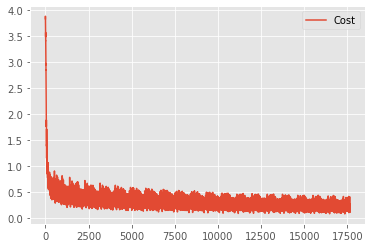

In [ ]:
plt.style.use("ggplot")
plt.plot(costs, label="Cost")
plt.legend()
plt.show()

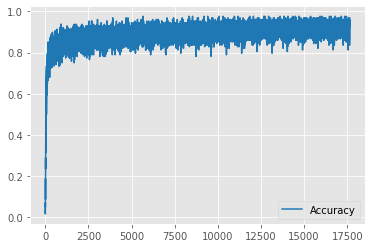

In [ ]:
plt.plot(acc_list, label="Accuracy", c="tab:blue")
plt.legend()
plt.show()

Saving the model

In [ ]:
# torch.save(model.state_dict(), "./cnn.pth")

# Testing

In [ ]:
model_path = "/content/cnn.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

FileNotFoundError: ignored

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    total_acc = 0
    for images, labels in loader:
        images = images.to(device)

        output = model(images).cpu()
        total = labels.size(0)
        preds = torch.argmax(output, 1)
        correct = (preds == labels).sum().item()
        total_acc += correct
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds, total_acc / len(test_dataset)

In [ ]:
model.eval()
all_preds, test_acc = get_all_preds(model, test_loader)
print("Accuracy on Test Set is", test_acc*100, "%")

Accuracy on Test Set is 86.58510638297872 %


In [ ]:
idx = 333
classes = test_dataset.classes
image, label = test_dataset[idx]
plt.imshow(image.squeeze(), cmap="gray")
print(f"Predicted Label: {classes[int(all_preds[idx])]}\nActual Label: {classes[label]}")

NameError: ignored

In [ ]:
torch.where(test_dataset.targets != all_preds)[0]

tensor([    7,    18,    25,  ..., 18786, 18794, 18797])

In [ ]:
import numpy as np

In [ ]:
np.intersect1d(torch.where(test_dataset.targets == 10)[0], torch.where(all_preds != 10)[0])

array([ 4651,  5046,  6510,  6660,  9073, 12191, 13473, 15146, 15220])